In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 


In [2]:
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import struct

# def parse_wf_from_binary(
#     path,
#     *,
#     channels=4,
#     n_events=500,
#     dtype="<f4",          # little-endian float32
#     event_header_bytes=28, # size of per-event header in bytes
#     sample_binning=8e-9    # seconds per sample (default 8 ns)
# ):
#     """
#     Reads binary waveform data and returns a tidy pandas DataFrame.

#     Each event layout: [event_header_bytes] + [channels * samples_per_waveform * dtype]

#     Args:
#         path (str or Path): Path to the binary file
#         channels (int): Number of waveform channels
#         n_events (int or None): Number of events to read. If None, read all events in file.
#         dtype (str): Data type of waveform samples
#         event_header_bytes (int): Size of per-event header in bytes (0 if none)
#         sample_binning (float): Sample spacing in seconds

#     Returns:
#         df (pd.DataFrame): Columns = TIME, CH1..CHn, event, event_time
#     """
#     path = Path(path)
#     file_size = path.stat().st_size
#     sample_bytes = np.dtype(dtype).itemsize

#     if n_events is None:
#         raise ValueError("You must provide n_events (no default samples_per_waveform available).")

#     # Compute number of samples per waveform
#     bytes_per_event = file_size // n_events
#     data_bytes_per_event = bytes_per_event - event_header_bytes
#     if data_bytes_per_event % (channels * sample_bytes) != 0:
#         raise ValueError("File size does not match given n_events and channels.")
#     samples_per_waveform = data_bytes_per_event // (channels * sample_bytes)

#     records = []

#     with path.open("rb") as f:
#         for evt in range(n_events):
#             # ---- Read header ----
#             event_id = None
#             event_time = None
#             if event_header_bytes:
#                 h = f.read(event_header_bytes)
#                 if len(h) < event_header_bytes:
#                     raise RuntimeError(f"Unexpected EOF while reading header for event {evt}")
#                 # interpret header minimally like SECOND: EVID + T
#                 if event_header_bytes >= 12:
#                     event_id = struct.unpack("<I", h[0:4])[0]
#                     event_time = struct.unpack("<Q", h[4:12])[0]

#             # ---- Read waveform ----
#             buf = f.read(data_bytes_per_event)
#             if len(buf) < data_bytes_per_event:
#                 raise RuntimeError(f"Unexpected EOF while reading waveform for event {evt}")

#             arr = np.frombuffer(buf, dtype=dtype).reshape(channels, samples_per_waveform)

#             # ---- Build tidy rows ----
#             for i in range(samples_per_waveform):
#                 row = {f"CH{ch+1}": arr[ch, i] for ch in range(channels)}
#                 row["event"] = event_id if event_id is not None else evt
#                 row["event_time"] = event_time if event_time is not None else 0
#                 row["TIME"] = (i + 1) * sample_binning
#                 records.append(row)

#     df = pd.DataFrame(records)
#     return df


In [3]:
# run_dir = "/data/marian/cigar/runs/20251015_Xe_Kr_17deg_54.5V_Majority"
# filename = f"{run_dir}/Acq_dig2-192.168.0.254_20251015160926-16.bin"

run_dir = "/home/marian/CIGAR_ANALYSIS/CIGAR/data/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority"
filename = f"{run_dir}/Acq_dig2-192.168.0.254_20251016120012-18.bin"

df = parse_data.parse_wf_from_binary(filename)  
df.head()


,CH1,CH2,CH3,CH4,event,event_time,TIME
0,-595.744568,-242.829224,-444.801422,-553.485229,4465,226739007948,8.000000e-09
1,-601.636963,-291.714020,-463.385925,-562.750916,4465,226739007948,1.600000e-08
2,-603.232788,-328.699615,-481.234406,-577.539124,4465,226739007948,2.400000e-08
3,-603.969360,-356.791504,-490.434662,-594.045532,4465,226739007948,3.200000e-08
4,-605.196960,-387.030151,-493.992096,-601.408936,4465,226739007948,4.000000e-08


In [4]:
# Filter for a specific event (change index as needed)
event_list = df['event'].unique()
print(len(event_list))

500


In [5]:
channels = ['CH1', 'CH2', 'CH3', 'CH4']
# channels = ['CH2', 'CH3', 'CH4', 'CH5']

In [6]:
selected_event = 40
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event


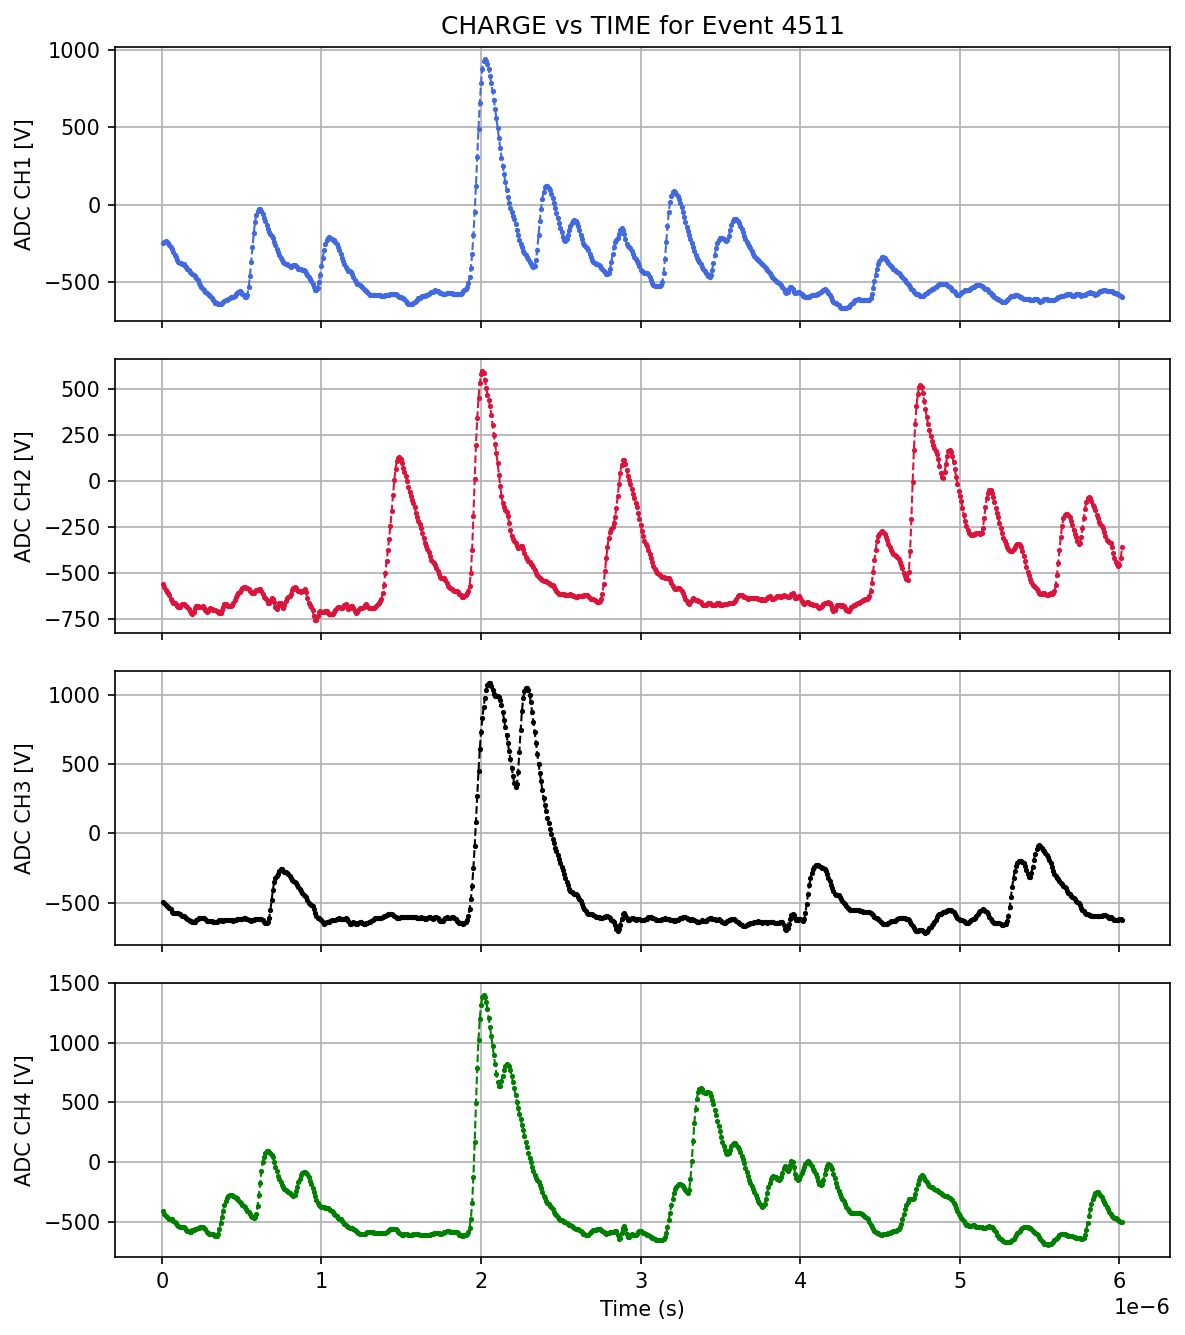

In [7]:
# Create subplots: 2 rows, 1 column
fig, axs = plt.subplots(4, 1, figsize=(8, 9), dpi=150, sharex=True)
colors = ['royalblue', 'crimson', 'black', 'green']

axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]}')

# Plot CHs
for i in range(4):
    # axs[i].plot(df_event['TIME'], (df_event[f'{channels[i]}']-df_event[df_event['TIME']<2e-9][f'{channels[i]}'].mean()), marker='.', linestyle='--',
    axs[i].plot(df_event['TIME'].values, df_event[f'{channels[i]}'].values, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{channels[i]}')
    axs[i].set_ylabel(f'ADC {channels[i]} [V]')
    axs[i].grid(True)

axs[-1].set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()